[E-07]camera_sticker
* 목적 : 이미지 내 얼굴을 검출하여 key point 를 생성하고, 좌표값을 이용하여 이미지를 위에 올려보기.
* 과정 : 대상 이미지에서 dlib 얼굴 검출기를 활용하여 landmark 좌표를 생성하고, 고양이 스티커를 얼굴에 올린다.
* 목표 : 얼굴의 landmark 를 정확히 검출하고 스티커 합성을 성공할 것 / 다양한 조건의 원본이미지에도 robust 할 것. 그렇지 못하다면 이유를 살펴볼 것 

---

1. 자기만의 카메라앱 기능 구현을 완수하였다.
    - 얼굴 영역과 랜드마크를 정확하게 검출하고, 스티커 사진을 합성시키는 데 성공하였다.
2. 스티커 이미지를 정확한 원본 위치에 반영하였다.
    - 정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.
3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.
    - 얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.
---

# 0. 공통 활용 모듈 import

In [4]:
import cv2
import dlib
import matplotlib.pyplot as plt
import numpy as np
import os

print(cv2.__version__)
print(dlib.__version__)

4.5.3
19.22.1


# 1. 고양이 스티커 다운로드
https://www.flaticon.com/free-icon/cat-whiskers_24674?term=cat%20nose&page=1&position=1

# 2. 얼굴 검출 & 랜드마크 검출하기

#### 사진준비

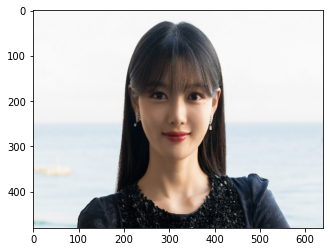

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/front.png'
img_bgr = cv2.imread(my_image_path)  
img_bgr = cv2.resize(img_bgr, (640, 480)) 
img_show = img_bgr.copy()     
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  
plt.imshow(img_rgb)
plt.show()

#### face detection

rectangles[[(221, 139) (407, 325)]]


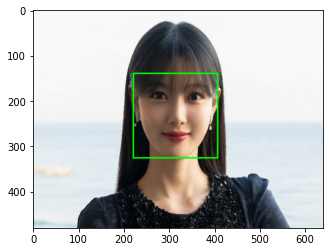

In [5]:
detector_hog = dlib.get_frontal_face_detector() 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  
dlib_rects = detector_hog(img_rgb, 1)  

print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### face landmark

68


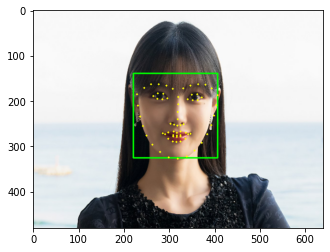

In [6]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 3. 스티커 적용 위치 확인하기

In [7]:
# 스티커 위치 계산
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) 
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(319, 240)
(x,y) : (319,240)
(w,h) : (187,187)


(187, 187, 3)


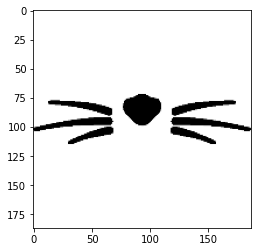

In [9]:
# 스티커 이미지를 읽어와 윗 단계에서 계산한 크기로 resize
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_whisker.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

plt.imshow(img_sticker)
plt.show()

In [11]:
# 이미지 시작점인 top-left 좌표로 x, y 좌표 변경
refined_x = x - w // 2  # left
refined_y = y - h // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (226,147)


# 4. 스티커 적용하기

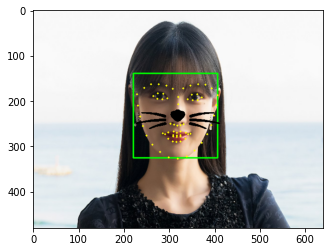

In [12]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

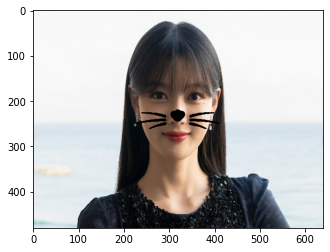

In [13]:
# 결과만 출력
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) 
plt.show()

# 5. 문제점 찾아보기

#### 다른 사진 적용 : 옆면도 잘 인식하는가?

rectangles[[(141, 112) (409, 379)]]


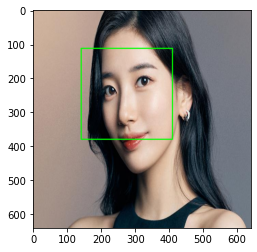

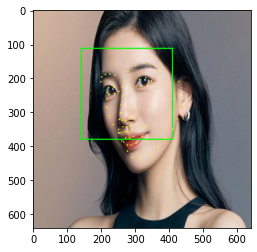

(256, 301)
(x,y) : (256,301)
(w,h) : (269,269)
(x,y) : (122,167)


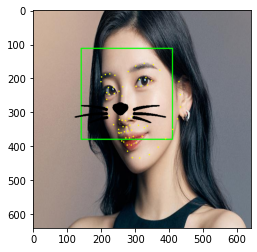

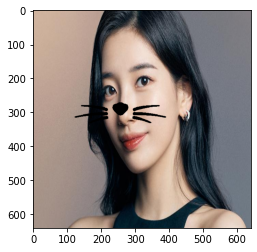

In [20]:
###----- Test1 -----###

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/side.png'
img_bgr = cv2.imread(my_image_path)  
img_bgr = cv2.resize(img_bgr, (640, 640))    
img_show = img_bgr.copy()    

# Face Detection
detector_hog = dlib.get_frontal_face_detector()   
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  
dlib_rects = detector_hog(img_rgb, 1)  

print(dlib_rects)   

# 이미지 위에 얼굴의 bounding box 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


# landmark 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 개별 위치 저장
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# 이미지에 landmark 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) 

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


# 스티커 위치 및 크기 계산
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) 
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y)) 
    print ('(w,h) : (%d,%d)'%(w,h))   

# 스티커 사이즈 조정
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_whisker.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))

# 이미지 시작점인 top-left 좌표로 x, y 좌표 변경
refined_x = x - w // 2  # left
refined_y = y - h // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# 원본 이미지에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


# 결과만 출력
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))  
plt.show()

rectangles[[(191, 118) (414, 341)]]


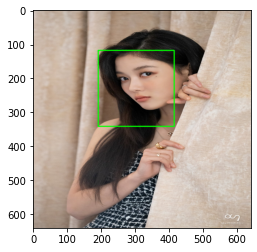

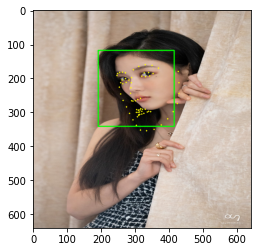

(286, 244)
(x,y) : (286,244)
(w,h) : (224,224)
(x,y) : (174,132)


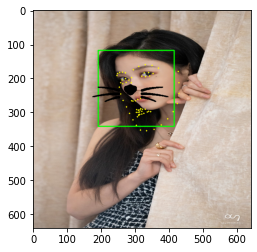

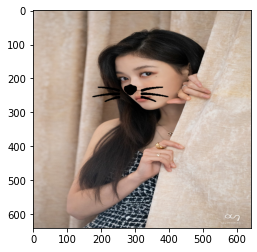

In [23]:
###----- Test2 -----###

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/side2.png'
img_bgr = cv2.imread(my_image_path)  
img_bgr = cv2.resize(img_bgr, (640, 640))    
img_show = img_bgr.copy()    

# Face Detection
detector_hog = dlib.get_frontal_face_detector()   
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  
dlib_rects = detector_hog(img_rgb, 1)  

print(dlib_rects)   

# 이미지 위에 얼굴의 bounding box 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


# landmark 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 개별 위치 저장
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# 이미지에 landmark 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) 

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


# 스티커 위치 및 크기 계산
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) 
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y)) 
    print ('(w,h) : (%d,%d)'%(w,h))   

# 스티커 사이즈 조정
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_whisker.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))

# 이미지 시작점인 top-left 좌표로 x, y 좌표 변경
refined_x = x - w // 2  # left
refined_y = y - h // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# 원본 이미지에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


# 결과만 출력
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))  
plt.show()

rectangles[]


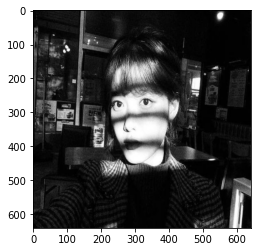

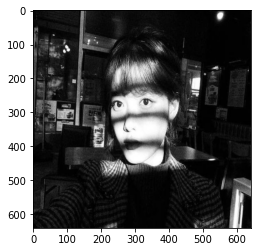

(x,y) : (174,132)


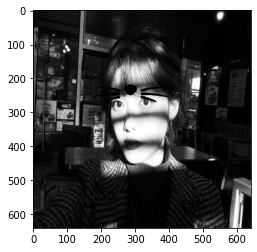

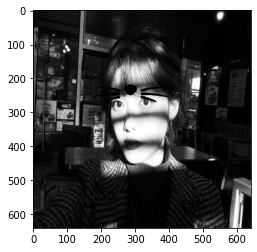

In [24]:
###----- Test3 -----###

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/dark.png'
img_bgr = cv2.imread(my_image_path)  
img_bgr = cv2.resize(img_bgr, (640, 640))    
img_show = img_bgr.copy()    

# Face Detection
detector_hog = dlib.get_frontal_face_detector()   
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  
dlib_rects = detector_hog(img_rgb, 1)  

print(dlib_rects)   

# 이미지 위에 얼굴의 bounding box 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


# landmark 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 개별 위치 저장
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# 이미지에 landmark 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) 

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


# 스티커 위치 및 크기 계산
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) 
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y)) 
    print ('(w,h) : (%d,%d)'%(w,h))   

# 스티커 사이즈 조정
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_whisker.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))

# 이미지 시작점인 top-left 좌표로 x, y 좌표 변경
refined_x = x - w // 2  # left
refined_y = y - h // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# 원본 이미지에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


# 결과만 출력
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))  
plt.show()

# 6. 회고

    * 문제점 
- landmark 모델이 2D 인 점이 크게 작용한다. 깊이를 설정할 수 없기 때문에 얼굴이 정면이 아니면 landmark가 뭉개진다. 
- 어두운 사진에서는 얼굴을 인식하지 못한다. 따라서 고양이 스티커도 엉뚱한 곳에 붙었다. 
- 고개 각도에 따라 test를 해보았는데 모든 눈코입이 다 정면에서 보이더라도 landmark 는 정면이 아닐때 무조건 이그러진다. 
- 고개를 어떻게 돌리느냐에 따라 (yaw roll pitch)에 관계없이 robust한 landmark 모델을 훈련시킬 필요가 있다고 생각했다.
